In [382]:
import pandas as pd

filepath = '/Users/hermansamuelsen/Desktop/Infor-Cogito/Enablement-Session/US_ECOMM_RECORDS_2020.csv'
data = pd.read_csv(filepath)
data_original = data.copy()


In [383]:
data.head(2)

,OrderDate,RowID,OrderID,ShipMode,CustomerID,Segment,Country,City,State,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit
0,2020-01-01,849,CA-2017-107503,Standard Class,GA-14725,Consumer,United States,Lorain,Ohio,44052,East,FUR-FU-10003878,Furniture,Furnishings,Linden 10 Round Wall Clock Black,48.896,4,0.2,8.5568
1,2020-01-01,4010,CA-2017-144463,Standard Class,SC-20725,Consumer,United States,Los Angeles,California,90036,West,FUR-FU-10001215,Furniture,Furnishings,Howard Miller 11-1/2 Diameter Brentwood Wall C...,474.430,11,0.0,199.2606


In [384]:
data["Cost"] = (data["Sales"] - data["Profit"])/data["Quantity"]

In [385]:
data["Margin"] = data["Profit"]/data["Sales"]

In [386]:
data.head()

,OrderDate,RowID,OrderID,ShipMode,CustomerID,Segment,Country,City,State,PostalCode,...,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit,Cost,Margin
0,2020-01-01,849,CA-2017-107503,Standard Class,GA-14725,Consumer,United States,Lorain,Ohio,44052,...,FUR-FU-10003878,Furniture,Furnishings,Linden 10 Round Wall Clock Black,48.896,4,0.2,8.5568,10.0848,0.1750
1,2020-01-01,4010,CA-2017-144463,Standard Class,SC-20725,Consumer,United States,Los Angeles,California,90036,...,FUR-FU-10001215,Furniture,Furnishings,Howard Miller 11-1/2 Diameter Brentwood Wall C...,474.430,11,0.0,199.2606,25.0154,0.4200
2,2020-01-01,6683,CA-2017-154466,First Class,DP-13390,Home Office,United States,Franklin,Wisconsin,53132,...,OFF-BI-10002012,Office Supplies,Binders,Wilson Jones Easy Flow II Sheet Lifters,3.600,2,0.0,1.7280,0.9360,0.4800
3,2020-01-01,8070,CA-2017-151750,Standard Class,JM-15250,Consumer,United States,Huntsville,Texas,77340,...,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,454.560,5,0.2,-107.9580,112.5036,-0.2375
4,2020-01-01,8071,CA-2017-151750,Standard Class,JM-15250,Consumer,United States,Huntsville,Texas,77340,...,FUR-FU-10002116,Furniture,Furnishings,Tenex Carpeted Granite-Look or Clear Contempor...,141.420,5,0.6,-187.3815,65.7603,-1.3250


In [387]:
def get_coefficient_variation(data, feature): 
    grouped_data = data.groupby(feature)
    mean, std = grouped_data["Margin"].mean(), grouped_data["Margin"].std()
    df = pd.concat([mean, std], axis = 1).reset_index()
    df.columns = [feature, "Mean", "Std"]
    df["CoefficientOfVariation"] = (df["Std"]/df["Mean"])**2

    return df.sort_values(by = "CoefficientOfVariation")
    

In [388]:

category = get_coefficient_variation(data, "Category")
sub_category = get_coefficient_variation(data, "SubCategory")

In [389]:
category
# CoefficientOfVariation is here low enough to only use categories for groupings. This gives more data point to fit 
# the clustering models within each group. We therefore dont need to group using the SubCategory. 

,Category,Mean,Std,CoefficientOfVariation
2,Technology,0.162107,0.221497,1.866943
1,Office Supplies,0.128125,0.567459,19.615620
0,Furniture,0.038584,0.354826,84.568818


In [390]:
sub_category

,SubCategory,Mean,Std,CoefficientOfVariation
10,Labels,0.435285,0.064162,0.021728
12,Paper,0.422968,0.066004,0.024352
7,Envelopes,0.422465,0.065931,0.024355
6,Copiers,0.319432,0.124438,0.151757
2,Art,0.251755,0.108777,0.186689
8,Fasteners,0.327422,0.175865,0.288497
0,Accessories,0.227836,0.156166,0.469816
15,Supplies,0.119110,0.175106,2.161255
13,Phones,0.113920,0.182104,2.555285
16,Tables,-0.158389,0.271052,2.928571


In [391]:
# We then group the data into the different Categories and start doing feature engineering for each group, generating more numerical features. 

def split_data(feature, data):

    categories = list(data[feature].unique())
    dataframes = {}

    for c in categories: 
        df = data[data[feature] == c]
        dataframes[c] = df
        
    return dataframes

grouped_dataframes = split_data("Category", data)
grouped_dataframes.keys()

dict_keys(['Furniture', 'Office Supplies', 'Technology'])

In [392]:
from datetime import datetime

def add_average_margin_feature(dataframe):
    means = dataframe.groupby("ProductName")["Margin"].mean().reset_index()
    means.columns = ["ProductName", "MeanMarging"]
    new_df = pd.merge(means, dataframe, on = "ProductName")
    return new_df 
    

def add_average_cost_per_unit_feature(dataframe):
    dataframe.loc[:, "CostPerUnit"] = dataframe["Cost"]/dataframe["Quantity"]
    means = dataframe.groupby("ProductName")["CostPerUnit"].mean().reset_index()
    means.columns = ["ProductName", "MeanCostPerUnit"]
    new_df = pd.merge(means, dataframe, on = "ProductName")
    return new_df 

def add_average_sales_in_past_per_product(n_months, dataframe):
    dataframe["OrderDate"] = pd.to_datetime(dataframe["OrderDate"])
    last_date = dataframe["OrderDate"].max()
    n_months_ago = last_date - pd.DateOffset(months = n_months)
    print(n_months_ago)
    filtered_data = dataframe[dataframe["OrderDate"] >= n_months_ago]
    meanSales = filtered_data.groupby("ProductName")["Sales"].mean().reset_index()
    meanSales.columns = ["ProductName", "AverageSalesPastMonths"]
    new_df = pd.merge(meanSales, dataframe, on = "ProductName")
    return new_df
    

    

In [393]:
add_average_sales_in_past_per_product(6, grouped_dataframes["Technology"])

2020-06-30 00:00:00


/var/folders/m_/52cv0jg50ks4sf87x_jwf8x40000gn/T/ipykernel_3622/3733414764.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["OrderDate"] = pd.to_datetime(dataframe["OrderDate"])


,ProductName,AverageSalesPastMonths,OrderDate,RowID,OrderID,ShipMode,CustomerID,Segment,Country,City,...,Region,ProductID,Category,SubCategory,Sales,Quantity,Discount,Profit,Cost,Margin
0,3D Systems Cube Printer 2nd Generation Magenta,5199.960,2020-10-05,6341,CA-2017-143112,Standard Class,TS-21370,Corporate,United States,New York City,...,East,TEC-MA-10001047,Technology,Machines,5199.960,4,0.0,1351.9896,961.9926,0.260000
1,3D Systems Cube Printer 2nd Generation White,1039.992,2020-11-21,6364,CA-2017-110443,Standard Class,CK-12205,Consumer,United States,Renton,...,West,TEC-MA-10002073,Technology,Machines,1039.992,1,0.2,103.9992,935.9928,0.100000
2,AT&T 1080 Corded phone,150.689,2020-04-07,9444,CA-2017-165904,Standard Class,HR-14770,Home Office,United States,Jacksonville,...,South,TEC-PH-10000576,Technology,Phones,219.184,2,0.2,19.1786,100.0027,0.087500
3,AT&T 1080 Corded phone,150.689,2020-12-03,2465,CA-2017-148691,Standard Class,CS-12460,Consumer,United States,New York City,...,East,TEC-PH-10000576,Technology,Phones,136.990,1,0.0,36.9873,100.0027,0.270000
4,AT&T 1080 Corded phone,150.689,2020-12-27,2570,CA-2017-134404,Same Day,DR-12880,Corporate,United States,Newark,...,East,TEC-PH-10000576,Technology,Phones,164.388,2,0.4,-35.6174,100.0027,-0.216667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,iOttie XL Car Mount,111.944,2020-11-04,8912,CA-2017-102610,Standard Class,CA-12265,Consumer,United States,Chattanooga,...,South,TEC-PH-10000127,Technology,Phones,143.928,9,0.2,-32.3838,19.5902,-0.225000
555,invisibleSHIELD by ZAGG Smudge-Free Screen Pro...,66.563,2020-02-23,6028,CA-2017-136007,Standard Class,AC-10615,Corporate,United States,Seattle,...,West,TEC-PH-10003589,Technology,Phones,71.960,5,0.2,25.1860,9.3548,0.350000
556,invisibleSHIELD by ZAGG Smudge-Free Screen Pro...,66.563,2020-07-30,7739,CA-2017-141103,Standard Class,JF-15355,Consumer,United States,Baltimore,...,East,TEC-PH-10003589,Technology,Phones,89.950,5,0.0,43.1760,9.3548,0.480000
557,invisibleSHIELD by ZAGG Smudge-Free Screen Pro...,66.563,2020-09-04,3081,CA-2017-101182,First Class,KB-16405,Home Office,United States,Apple Valley,...,West,TEC-PH-10003589,Technology,Phones,43.176,3,0.2,15.1116,9.3548,0.350000


In [394]:
for key, df in grouped_dataframes.items(): 
    grouped_dataframes[key] = add_average_margin_feature(df)

for key, df in grouped_dataframes.items(): 
    grouped_dataframes[key] = add_average_cost_per_unit_feature(df)

for key, df in grouped_dataframes.items():
    grouped_dataframes[key] = add_average_sales_in_past_per_product(12, df)

2019-12-30 00:00:00
2019-12-30 00:00:00
2019-12-30 00:00:00


In [395]:
grouped_dataframes["Technology"].head()

,ProductName,AverageSalesPastMonths,MeanCostPerUnit,MeanMarging,OrderDate,RowID,OrderID,ShipMode,CustomerID,Segment,...,ProductID,Category,SubCategory,Sales,Quantity,Discount,Profit,Cost,Margin,CostPerUnit
0,3D Systems Cube Printer 2nd Generation Magenta,5199.960000,240.498150,0.260000,2020-10-05,6341,CA-2017-143112,Standard Class,TS-21370,Corporate,...,TEC-MA-10001047,Technology,Machines,5199.960,4,0.0,1351.9896,961.9926,0.2600,240.49815
1,3D Systems Cube Printer 2nd Generation White,1039.992000,935.992800,0.100000,2020-11-21,6364,CA-2017-110443,Standard Class,CK-12205,Consumer,...,TEC-MA-10002073,Technology,Machines,1039.992,1,0.2,103.9992,935.9928,0.1000,935.99280
2,ARKON Windshield Dashboard Air Vent Car Mount ...,67.800000,4.152750,0.020000,2020-01-14,9861,CA-2017-113278,Standard Class,HR-14770,Home Office,...,TEC-PH-10000169,Technology,Phones,67.800,4,0.0,1.3560,16.6110,0.0200,4.15275
3,AT&T 1080 Corded phone,173.520667,66.668467,0.046944,2020-04-07,9444,CA-2017-165904,Standard Class,HR-14770,Home Office,...,TEC-PH-10000576,Technology,Phones,219.184,2,0.2,19.1786,100.0027,0.0875,50.00135
4,AT&T 1080 Corded phone,173.520667,66.668467,0.046944,2020-12-03,2465,CA-2017-148691,Standard Class,CS-12460,Consumer,...,TEC-PH-10000576,Technology,Phones,136.990,1,0.0,36.9873,100.0027,0.2700,100.00270


In [410]:
features = ["AverageSalesPastMonths", "MeanCostPerUnit", "MeanMarging"]
test_data = grouped_dataframes["Technology"][features]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
test_data_ss = ss.fit_transform(test_data)

In [411]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
number_of_clusters = [x for x in range(2, 11)]
intertia = []
silhouette = []
models = []

for n in number_of_clusters: 
   
    means = KMeans(n_clusters = n, random_state = 42)
    predicted = means.fit_predict(test_data_ss)
    intertia.append(means.inertia_)
    silhouette.append(silhouette_score(test_data_ss, predicted))
    models.append(means)



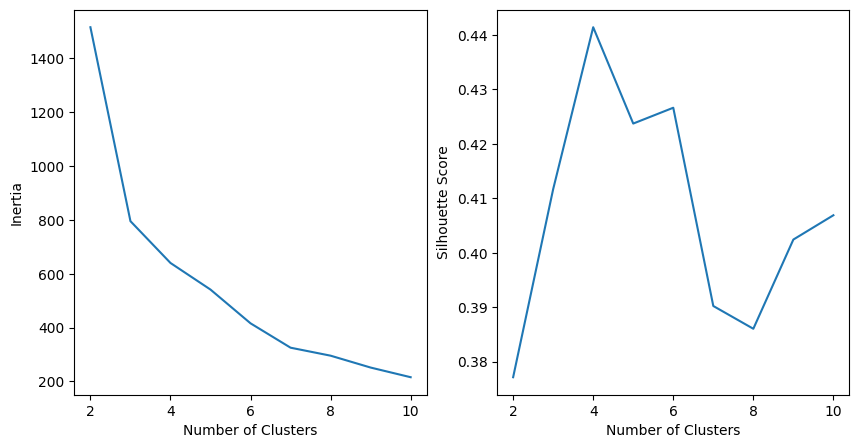

In [412]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(n_clusters, intertia)
ax[0].set_xlabel("Number of Clusters")
ax[0].set_ylabel("Inertia")
ax[1].plot(n_clusters, silhouette)
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("Silhouette Score")
plt.show()

In [399]:
test_data.shape

(624, 4)

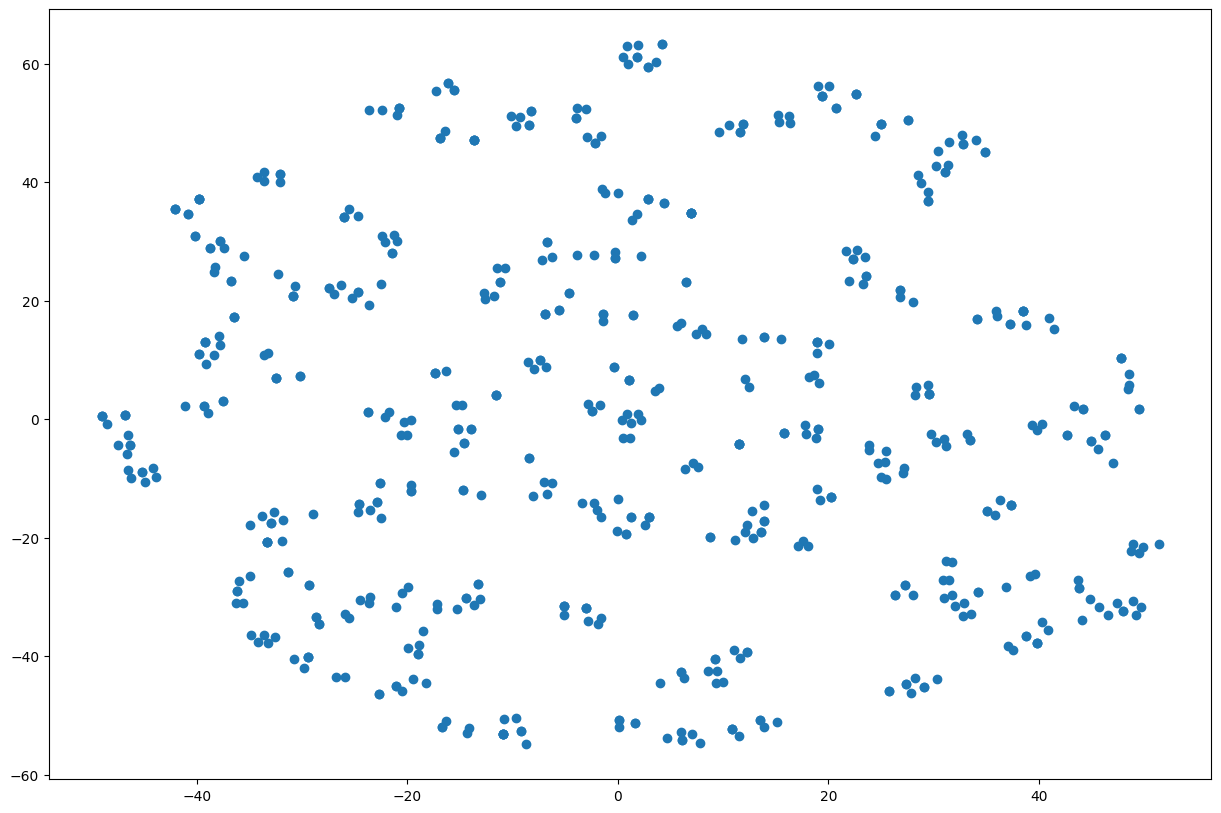

In [413]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2,
        init="pca",
        max_iter=500,
        n_iter_without_progress=150,
        perplexity=10,
        random_state=0)

data_embedded = embedding.fit_transform(test_data_ss)

fig, ax = plt.subplots(figsize = (15, 10))

ax.scatter(x = data_embedded[:, 0], y = data_embedded[:, 1])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

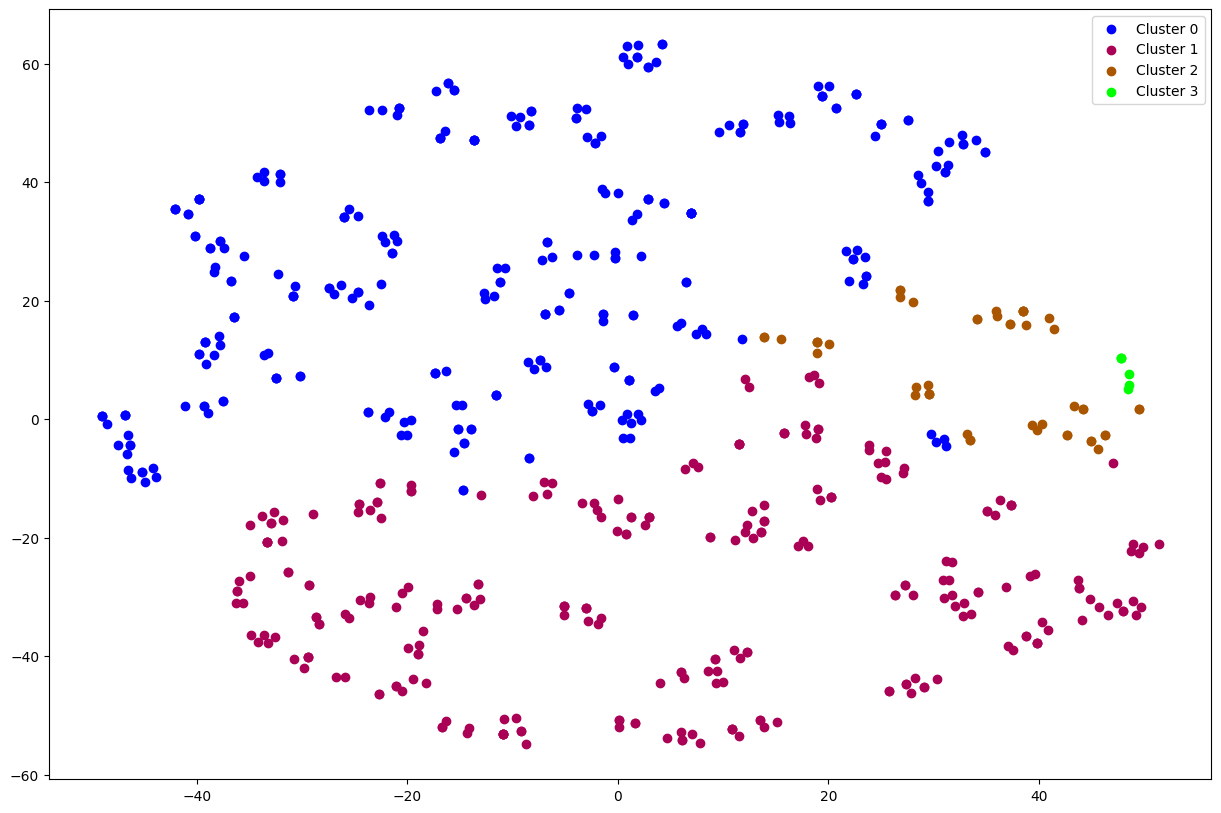

In [414]:
best_model = models[2]
labels = best_model.predict(test_data_ss)
cmap = plt.get_cmap('brg', best_model.n_clusters)

unique_labels = set(labels)
fig, ax = plt.subplots(figsize = (15, 10))

for l in unique_labels: 
    cluster = data_embedded[labels == l]
    ax.scatter(cluster[:, 0], cluster[:, 1], c = cmap(l), label = f"Cluster {l}")

ax.legend()



In [415]:
data = grouped_dataframes["Technology"].copy()
data["Clusters"] = labels
get_coefficient_variation(data, "Clusters")

,Clusters,Mean,Std,CoefficientOfVariation
0,0,0.292406,0.105446,0.130045
2,2,0.198209,0.276167,1.941332
3,3,0.167500,0.363590,4.711873
1,1,0.010097,0.207558,422.535029


In [425]:
data[labels == 1]["SubCategory"].value_counts()

SubCategory
Phones         178
Accessories     77
Machines        13
Copiers          1
Name: count, dtype: int64